In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

C:\Users\wjssm\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def sin(x,T=100) :
    return np.sin(2.0*np.pi*x/T)

In [3]:
def toy_problem(T=100,ampl=0.05) :
    x=np.arange(0,2*T+1)
    noise=ampl*np.random.uniform(low=-1,high=1,size=len(x))
    return sin(x)+noise

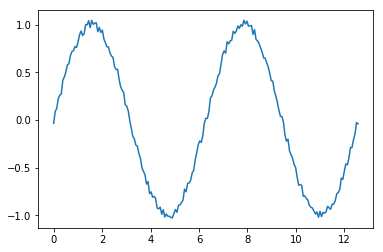

In [4]:
f=toy_problem(T=100,ampl=0.05)
x=np.arange(0,200+1)*(np.pi*4)/200
plt.plot(x,f)

In [5]:
length_of_sequence=2*100
maxlen=25

data=[]
target=[]
for i in range(0,length_of_sequence-maxlen+1) :
    data.append(f[i:(i+maxlen)])
    target.append(f[i+maxlen])

In [6]:
X=np.array(data)
X=np.array(data).reshape(len(data),maxlen,1)
y=np.array(target).reshape(len(data),1)

## Tensorflow

In [7]:
n_hidden =32
n_batch = 176

n_in = 1
n_out = 1

In [8]:
# 전체 90%를 train data
train_size = int(len(X) * 0.9)
# 10% test data
test_size = len(y) - train_size

trainX = np.array(X[0:train_size])
trainY = np.array(y[0:train_size])

testX = np.array(X[train_size:len(X)])
testY = np.array(y[train_size:len(y)])

In [9]:
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, shape=[])

In [10]:
def inference(x,  n_batch, maxlen=None, n_hidden=None, n_in = None, n_out=None):
    def weight_variable(name1, shape1):
        return tf.get_variable(name = name1, shape = shape1,
                               initializer = tf.contrib.layers.xavier_initializer(),
                               dtype = tf.float32)
    
    def bias_variable(name1, shape1):
        return tf.get_variable(name = name1, shape = shape1,
                               initializer = tf.contrib.layers.xavier_initializer(),
                               dtype = tf.float32)
    
    state = tf.zeros( shape = (n_batch, n_hidden)) #initial hidden layer h_t-1
    c = tf.zeros( shape = (n_batch, n_hidden)) #initial cell c_t-1
    
    outputs = []
    
    #LSTM Variables
    Wxa = weight_variable('Wxa', (n_in, n_hidden))
    Wha = weight_variable('Wha', (n_hidden, n_hidden))
    Wx_input = weight_variable('Wx_input', (n_in, n_hidden))
    Wh_input = weight_variable('Wh_input', (n_hidden, n_hidden))
    Wx_output = weight_variable('Wx_output', (n_in, n_hidden))
    Wh_output = weight_variable('Wh_output', (n_hidden, n_hidden))
    Wxc = weight_variable('Wxc', (n_in, n_hidden))
    Whc = weight_variable('Whc', (n_hidden, n_hidden))
    
    ba = bias_variable('ba', (1, n_hidden))
    bi = bias_variable('bi', (1, n_hidden))
    bo = bias_variable('bo', (1, n_hidden))
    bc = bias_variable('bc', (1, n_hidden))
    
    for t in range(maxlen):
        f = tf.sigmoid( tf.matmul(x[:, t, :], Wxa) + tf.matmul(state, Wha) + ba)
        i = tf.sigmoid( tf.matmul(x[:, t, :], Wx_input) + tf.matmul(state, Wh_input) + bi)
        o = tf.sigmoid( tf.matmul(x[:, t, :], Wx_output) + tf.matmul(state, Wh_output) + bo)
        
        c = tf.multiply(c, f) + tf.multiply(i, tf.tanh(tf.matmul(x[:, t, :], Wxc) + tf.matmul(state, Whc) + bc))
        state = tf.multiply(tf.tanh(c), o)
        outputs.append(state)
    
    #Output
    output = outputs[-1] #마지막 값
    
    V = weight_variable('V', (n_hidden, n_out))
    out_b = bias_variable('out_b', (1, n_out))
    y = tf.matmul(output, V) + out_b
    return y

In [11]:
y = inference(x,n_batch=n_batch, maxlen=maxlen, n_hidden=n_hidden,n_in = n_in, n_out=n_out)

In [12]:
def loss(y, t):
    mse = tf.reduce_mean(tf.square(y-t))
    return mse
def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    train_step = optimizer.minimize(loss)
    return train_step

loss = loss(y,t)
train_step = training(loss)

In [35]:
epochs = 1500
batch_size = 20

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = train_size // batch_size
from sklearn.utils import shuffle

In [36]:
my_loss = []
for epoch in range(epochs):
    X_, Y_ = shuffle(trainX, trainY)
    
    for i in range(n_batches):
        start = i* batch_size
        end = start + batch_size
    
    sess.run(train_step, feed_dict={
        x: X_[start:end], 
        t: Y_[start:end],
        n_batch: batch_size
    })
    
    val_loss = loss.eval(session=sess, feed_dict={
        x: testX, 
        t: testY, 
        n_batch: test_size
    })
    my_loss.append(val_loss)
    print("epoch:", epoch, "validation loss:", val_loss)

epoch: 0 validation loss: 2.0340762
epoch: 1 validation loss: 1.9303114
epoch: 2 validation loss: 1.8290151
epoch: 3 validation loss: 1.7318057
epoch: 4 validation loss: 1.6382833
epoch: 5 validation loss: 1.545176
epoch: 6 validation loss: 1.4539351
epoch: 7 validation loss: 1.365136
epoch: 8 validation loss: 1.2774754
epoch: 9 validation loss: 1.1911626
epoch: 10 validation loss: 1.1067247
epoch: 11 validation loss: 1.0244265
epoch: 12 validation loss: 0.94399613
epoch: 13 validation loss: 0.86712795
epoch: 14 validation loss: 0.7910449
epoch: 15 validation loss: 0.7176225
epoch: 16 validation loss: 0.64578414
epoch: 17 validation loss: 0.5759523
epoch: 18 validation loss: 0.50771606
epoch: 19 validation loss: 0.44254354
epoch: 20 validation loss: 0.3802624
epoch: 21 validation loss: 0.32088777
epoch: 22 validation loss: 0.2654158
epoch: 23 validation loss: 0.21488556
epoch: 24 validation loss: 0.17008112
epoch: 25 validation loss: 0.13088629
epoch: 26 validation loss: 0.09830435
epo

epoch: 233 validation loss: 0.002580153
epoch: 234 validation loss: 0.0025778124
epoch: 235 validation loss: 0.002508296
epoch: 236 validation loss: 0.0024669962
epoch: 237 validation loss: 0.0024780885
epoch: 238 validation loss: 0.0024938646
epoch: 239 validation loss: 0.00248756
epoch: 240 validation loss: 0.0022827892
epoch: 241 validation loss: 0.002125262
epoch: 242 validation loss: 0.002046507
epoch: 243 validation loss: 0.0020100542
epoch: 244 validation loss: 0.0020240315
epoch: 245 validation loss: 0.0020411739
epoch: 246 validation loss: 0.0021615901
epoch: 247 validation loss: 0.0022947656
epoch: 248 validation loss: 0.0023732083
epoch: 249 validation loss: 0.0023942492
epoch: 250 validation loss: 0.0023256834
epoch: 251 validation loss: 0.0022615495
epoch: 252 validation loss: 0.0022511322
epoch: 253 validation loss: 0.0023315242
epoch: 254 validation loss: 0.00240957
epoch: 255 validation loss: 0.0024929412
epoch: 256 validation loss: 0.002673149
epoch: 257 validation los

epoch: 466 validation loss: 0.0013680453
epoch: 467 validation loss: 0.0013262683
epoch: 468 validation loss: 0.0012870637
epoch: 469 validation loss: 0.0012346734
epoch: 470 validation loss: 0.001172444
epoch: 471 validation loss: 0.0011270805
epoch: 472 validation loss: 0.0011180165
epoch: 473 validation loss: 0.0011013369
epoch: 474 validation loss: 0.0010904685
epoch: 475 validation loss: 0.001090906
epoch: 476 validation loss: 0.0010955989
epoch: 477 validation loss: 0.001092643
epoch: 478 validation loss: 0.0010840402
epoch: 479 validation loss: 0.0010811975
epoch: 480 validation loss: 0.0011282873
epoch: 481 validation loss: 0.0012054722
epoch: 482 validation loss: 0.0012899168
epoch: 483 validation loss: 0.0014137218
epoch: 484 validation loss: 0.001446923
epoch: 485 validation loss: 0.0014763586
epoch: 486 validation loss: 0.0014605274
epoch: 487 validation loss: 0.0013771094
epoch: 488 validation loss: 0.0012538447
epoch: 489 validation loss: 0.0011528444
epoch: 490 validatio

epoch: 673 validation loss: 0.0010276976
epoch: 674 validation loss: 0.0010286756
epoch: 675 validation loss: 0.0010330866
epoch: 676 validation loss: 0.0010294758
epoch: 677 validation loss: 0.0010734698
epoch: 678 validation loss: 0.0011730202
epoch: 679 validation loss: 0.0012796902
epoch: 680 validation loss: 0.0013713394
epoch: 681 validation loss: 0.0014891103
epoch: 682 validation loss: 0.0015319318
epoch: 683 validation loss: 0.0014673857
epoch: 684 validation loss: 0.0013328625
epoch: 685 validation loss: 0.0011410101
epoch: 686 validation loss: 0.0010325578
epoch: 687 validation loss: 0.0010745763
epoch: 688 validation loss: 0.0012243711
epoch: 689 validation loss: 0.0013560408
epoch: 690 validation loss: 0.0014348989
epoch: 691 validation loss: 0.0013302355
epoch: 692 validation loss: 0.0011600851
epoch: 693 validation loss: 0.0010539184
epoch: 694 validation loss: 0.00103878
epoch: 695 validation loss: 0.0010995739
epoch: 696 validation loss: 0.0011698423
epoch: 697 validat

epoch: 887 validation loss: 0.0010494399
epoch: 888 validation loss: 0.001082161
epoch: 889 validation loss: 0.0011303137
epoch: 890 validation loss: 0.0011281711
epoch: 891 validation loss: 0.0011066442
epoch: 892 validation loss: 0.0010913216
epoch: 893 validation loss: 0.0010708175
epoch: 894 validation loss: 0.0010512962
epoch: 895 validation loss: 0.0010238076
epoch: 896 validation loss: 0.0010146205
epoch: 897 validation loss: 0.0010158154
epoch: 898 validation loss: 0.0010051725
epoch: 899 validation loss: 0.0010005584
epoch: 900 validation loss: 0.0010131196
epoch: 901 validation loss: 0.0010203947
epoch: 902 validation loss: 0.0010183777
epoch: 903 validation loss: 0.0010070461
epoch: 904 validation loss: 0.0010054243
epoch: 905 validation loss: 0.0010026187
epoch: 906 validation loss: 0.0009993651
epoch: 907 validation loss: 0.0010010526
epoch: 908 validation loss: 0.0010091936
epoch: 909 validation loss: 0.0010167564
epoch: 910 validation loss: 0.0010220048
epoch: 911 valida

epoch: 1097 validation loss: 0.0015487396
epoch: 1098 validation loss: 0.0014862232
epoch: 1099 validation loss: 0.001295506
epoch: 1100 validation loss: 0.0011770807
epoch: 1101 validation loss: 0.0011132982
epoch: 1102 validation loss: 0.0010924666
epoch: 1103 validation loss: 0.0011589687
epoch: 1104 validation loss: 0.0012433631
epoch: 1105 validation loss: 0.0013877642
epoch: 1106 validation loss: 0.0014648016
epoch: 1107 validation loss: 0.0013782313
epoch: 1108 validation loss: 0.0012499443
epoch: 1109 validation loss: 0.0011122158
epoch: 1110 validation loss: 0.0010359703
epoch: 1111 validation loss: 0.001068628
epoch: 1112 validation loss: 0.0011893349
epoch: 1113 validation loss: 0.0014852338
epoch: 1114 validation loss: 0.0017999914
epoch: 1115 validation loss: 0.002030245
epoch: 1116 validation loss: 0.0018158834
epoch: 1117 validation loss: 0.001605021
epoch: 1118 validation loss: 0.0014100728
epoch: 1119 validation loss: 0.0012598365
epoch: 1120 validation loss: 0.0011038

epoch: 1303 validation loss: 0.0010589355
epoch: 1304 validation loss: 0.0010366567
epoch: 1305 validation loss: 0.0011013913
epoch: 1306 validation loss: 0.0012006076
epoch: 1307 validation loss: 0.0011889925
epoch: 1308 validation loss: 0.0011018482
epoch: 1309 validation loss: 0.0010133716
epoch: 1310 validation loss: 0.0010322972
epoch: 1311 validation loss: 0.0011317548
epoch: 1312 validation loss: 0.0012673349
epoch: 1313 validation loss: 0.0012275574
epoch: 1314 validation loss: 0.0012175242
epoch: 1315 validation loss: 0.0011660317
epoch: 1316 validation loss: 0.0010638388
epoch: 1317 validation loss: 0.0010178877
epoch: 1318 validation loss: 0.0010089065
epoch: 1319 validation loss: 0.0010131171
epoch: 1320 validation loss: 0.0010188073
epoch: 1321 validation loss: 0.0010184716
epoch: 1322 validation loss: 0.0010255913
epoch: 1323 validation loss: 0.0010259562
epoch: 1324 validation loss: 0.0010187123
epoch: 1325 validation loss: 0.0010197008
epoch: 1326 validation loss: 0.001

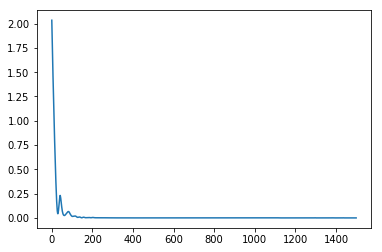

In [37]:
plt.plot(my_loss)

In [38]:
Z=X[:1]

In [39]:
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

In [40]:
for i in range(length_of_sequence - maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict={
        x: Z[-1:], 
        n_batch: 1
    })
    
    sequence_ = np.concatenate(
        (z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

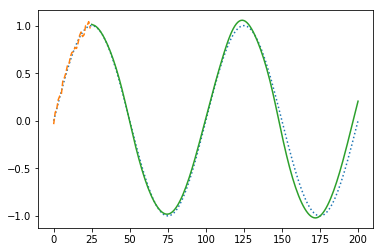

In [41]:
plt.plot(toy_problem(100, ampl=0), linestyle="dotted")
plt.plot(original, linestyle="dashed")
plt.plot(predicted)